In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def plot_img(img):
    plt.figure(figsize=(10,7))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
part1_single_objects = "../COTSDataset/Part 1 - Single Objects"
part2_multiple_objects = "../COTSDataset/Part 2 - Multiple Objects"
part3_complex_background = "../COTSDataset/Part 3 - Complex Background"

In [4]:
img_path = os.path.join(part2_multiple_objects, "academic_book_no", "1_colour.jpeg")
# img_path = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_7_mask.png")
# mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_8_mask.png")
mask = cv2.imread(mask_path)

In [5]:
# Extracting target bounding box from mask
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = mask.astype(np.uint8)
# Find contours in the mask
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize an empty list to store bounding boxes
bounding_boxes = []

# Loop through the detected contours
for cnt in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(cnt)
    
    # Add the bounding box coordinates to the list
    bounding_boxes.append((x, y, x + w, y + h))

# Find the minimum and maximum coordinates to create a bounding box around all masks
x1, y1 = min(box[0] for box in bounding_boxes), min(box[1] for box in bounding_boxes)
x2, y2 = max(box[2] for box in bounding_boxes), max(box[3] for box in bounding_boxes)

# Create the target bounding box that encompasses all masks
target_bbox = np.array([x1, y1, x2, y2])

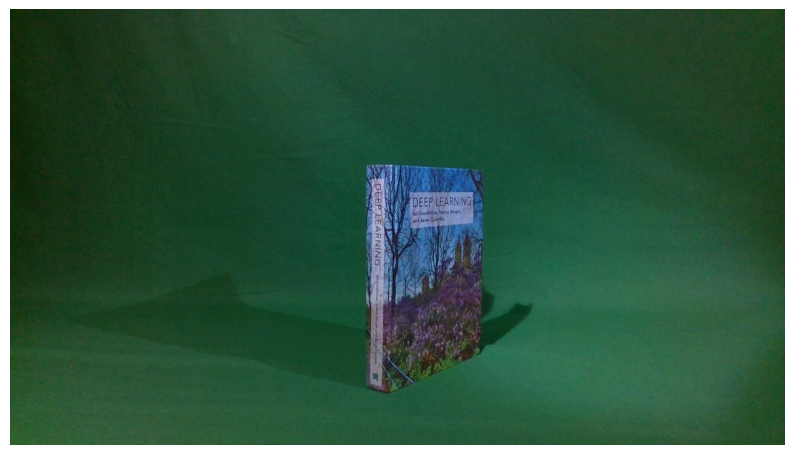

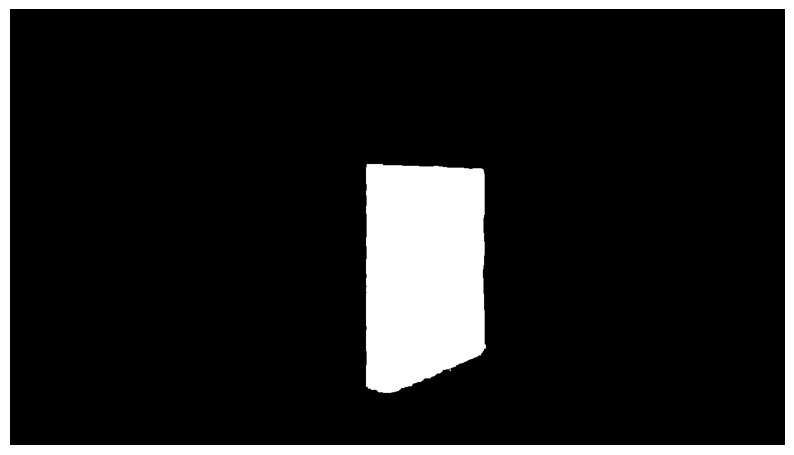

In [6]:
plot_img(img)
plot_img(mask)

In [7]:
from utils import *
from models import *
from env import *
from init import *
from agent import DQNAgent

CUDA is available! Using GPU for computations.


In [8]:
env = gym.make('DetectionEnv-v0', image = img, original_image = img, target_bbox = target_bbox)
_ = env.reset()
# PROBLEM WITH RENDERING

In [9]:
# Creating the environment
# env = DetectionEnv(img, img, target_bbox) #, feature_extractor=ResNet50FeatureExtractor(), target_size=RESNET50_TARGET_SIZE)
# env = gym.make('DetectionEnv-v0', image = img, original_image = img, target_bbox = target_bbox, feature_extractor=ResNet50FeatureExtractor(), target_size=RESNET50_TARGET_SIZE)
# _ = env.reset()

In [10]:
# env = DetectionEnv(img, img, target_bbox, feature_extractor=MobileNetV2FeatureExtractor(), target_size=MOBILENETV2_TARGET_SIZE)
# env = gym.make('DetectionEnv-v0', image = img, original_image = img, target_bbox = target_bbox, feature_extractor=MobileNetV2FeatureExtractor(), target_size=MOBILENETV2_TARGET_SIZE)
# _ = env.reset()

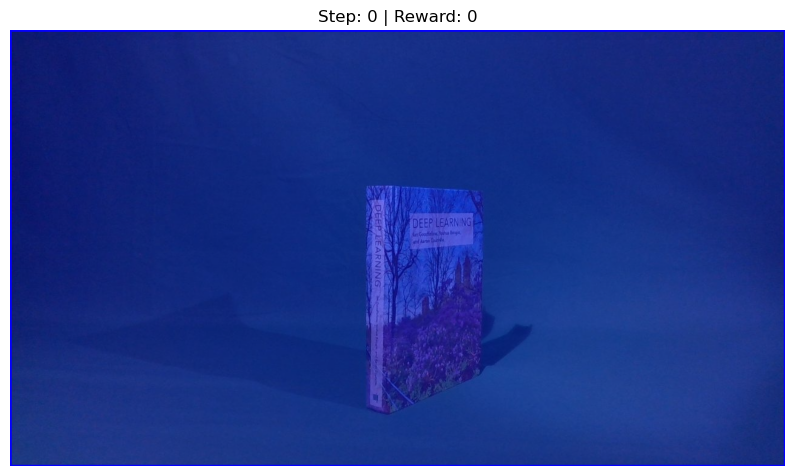

In [11]:
frame = env.display(do_display=True)

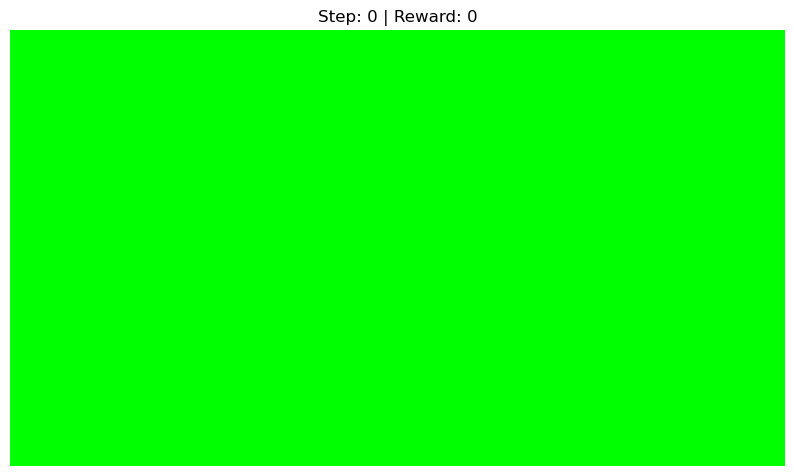

In [12]:
frame = env.display(do_display=True, mode='bbox')

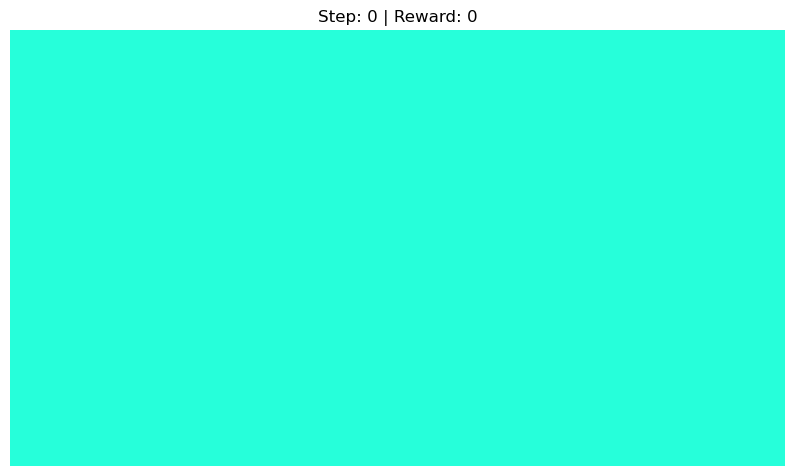

In [13]:
frame = env.display(do_display=True, mode='heatmap')

In [14]:
env.get_actions()

Actions:
0: Move right → 
1: Move left ←
2: Move up ↑
3: Move down ↓
4: Make bigger +
5: Make smaller -
6: Make fatter W
7: Make taller H
8: Trigger T


In [15]:
observation_space, info = env.reset()
print(observation_space)

[[0.0000000e+00 0.0000000e+00 1.2800000e+03 ... 2.3769828e-02
  1.9780377e-02 7.3685847e-02]]


In [16]:
env.observation_space

Box(0.0, 100.0, (2232,), float32)

Action: Make fatter W
Terminated:  False
Truncated:  False
Reward:  1
IoU 0.2946096620165964
Recall 0.6443358136473459


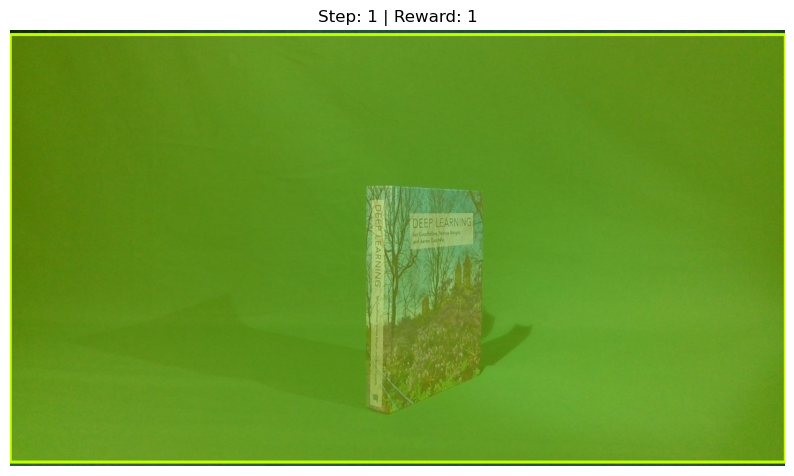

In [17]:
action = env.action_space.sample()

env.decode_action(action)

# Taking a step in the environment
next_state, reward, terminated, truncated, info = env.step(action)
print("Terminated: ", terminated)
print("Truncated: ", truncated)
print("Reward: ", reward)
print("IoU", info['iou'])
print("Recall", info['recall'])
_ = env.display(do_display=True, mode='image')

In [18]:
img_path2 = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
# img_path = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
img2 = cv2.imread(img_path2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

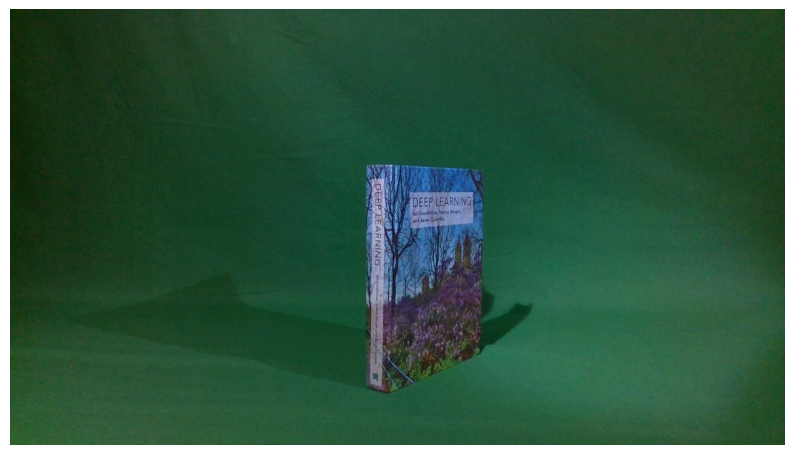

In [19]:
plot_img(img)

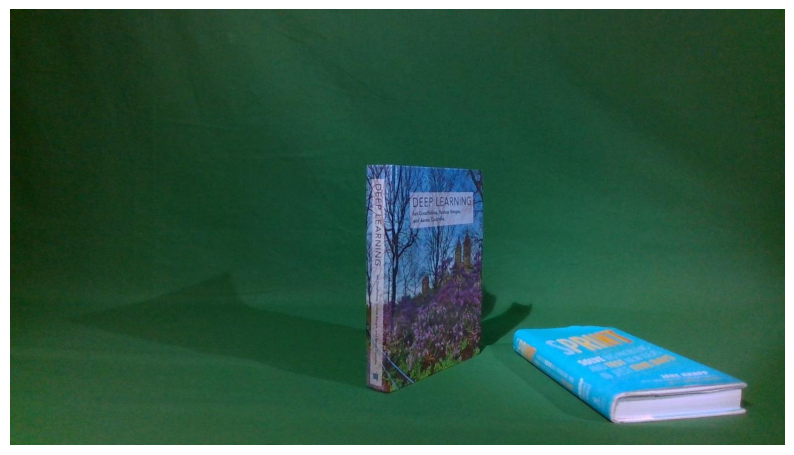

In [20]:
plot_img(img2)

In [21]:
def check(image1, image2):
    for i in range(len(image1)):
        for j in range(len(image1[0])):
            if image1[i][j] != image2[i][j]:
                print("Not equal")
                break

In [22]:
image1, _ = env.reset(image=img)
image2, _ = env.reset(image=img2)
check(image1, image2)

Not equal


In [23]:
image1, _ = env.reset(image=img)
image2, _ = env.reset(image=img)
check(image1, image2)

In [24]:
# Setting name
name = "Normal DQN"

# Creating the Replay_Buffer
replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# Creating the DQN agent
dqn_agent = DQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# Running the agent
dqn_agent.run()
# dqn_agent.load(path="models/" + name)

# Retrieving the episode info
dqn_episode_info = dqn_agent.get_episode_info()

# Printing the time taken to train the agent
print("Time taken to train the agent: {:.2f} seconds".format(dqn_episode_info["eps_duration"]))

# Saving the model
dqn_agent.save(path="models/" + name)

Episode: 1 Epsilon: 0.90 Average Reward: -47.0 Episode Length: 7 IoU: 0.32 Recall: 0.69
----------------------------------------------------------------------------------------------------
Episode: 2 Epsilon: 0.89 Average Reward: -47.5 Episode Length: 7 IoU: 0.29 Recall: 0.62
----------------------------------------------------------------------------------------------------
Episode: 3 Epsilon: 0.89 Average Reward: -46.666666666666664 Episode Length: 8 IoU: 0.31 Recall: 0.65
----------------------------------------------------------------------------------------------------
Episode: 4 Epsilon: 0.89 Average Reward: -46.75 Episode Length: 4 IoU: 0.30 Recall: 0.64
----------------------------------------------------------------------------------------------------
Episode: 5 Epsilon: 0.89 Average Reward: -47.4 Episode Length: 5 IoU: 0.30 Recall: 0.65
----------------------------------------------------------------------------------------------------
Episode: 6 Epsilon: 0.88 Average Reward:

KeyboardInterrupt: 

In [ ]:
# env.render()

In [ ]:
# dqn_agent.test()

In [ ]:
# env.close()

In [ ]:
# from stable_baselines3 import DQN

# model = DQN("MlpPolicy", env, verbose=1)
# obs, info = env.reset()

# # Train the model for a certain number of time steps
# total_timesteps = 10000
# update_frequency = 4  # Update the model every 4 steps
# for timestep in range(total_timesteps):
#     print(f"Timestep {timestep + 1}/{total_timesteps}")
#     print(obs)
#     obs_np = obs.detach().numpy()
#     action, _states = model.predict(obs_np, deterministic=True)
#     obs, reward, terminated, truncated, info = env.step(action[0])
    
#     # Incrementally train the model
#     if timestep % update_frequency == 0:
#         obs_np = obs.detach().numpy()
#         model.learn(obs_np, action, reward, obs_np, terminated)  # Update the model using a single step of experience

#     if terminated or truncated:
#         obs, info = env.reset()


In [ ]:
# obs, info = env.reset()
# while True:
#     obs = obs.detach().numpy()
#     action, _states = model.predict(obs, deterministic=True)
#     print(action[0])
#     obs, reward, terminated, truncated, info = env.step(action[0])
#     if terminated or truncated:
#         obs, info = env.reset()

In [ ]:
rewards_list = dqn_episode_info["episode_avg_rewards"]
# Plotting the rewards
plt.figure(figsize=(12,8))
plt.plot(rewards_list, label='Total Reward', color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

NameError: name 'dqn_episode_info' is not defined

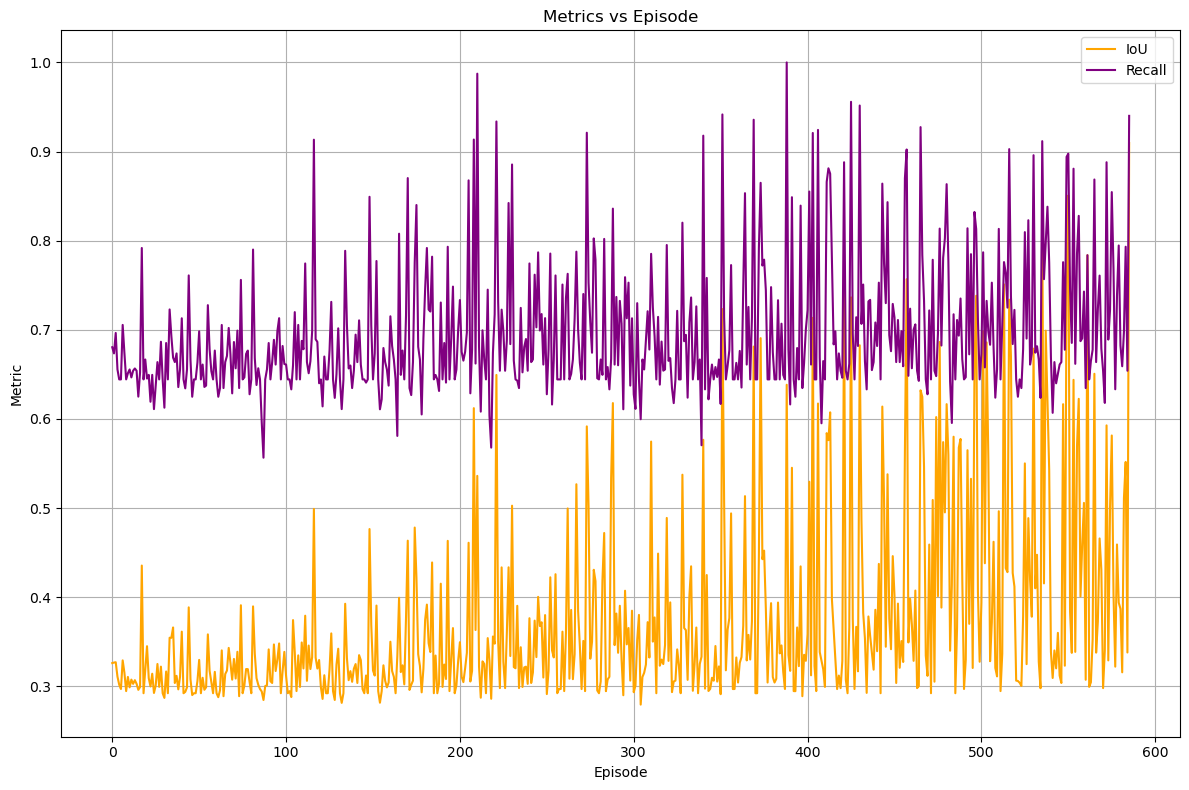

In [ ]:
iou_list = dqn_episode_info["iou"]
recall_list = dqn_episode_info["recall"]

plt.figure(figsize=(12,8))
plt.plot(iou_list, label='IoU', color='orange')
plt.plot(recall_list, label='Recall', color='purple')
plt.xlabel('Episode')
plt.ylabel('Metric')
plt.title('Metrics vs Episode')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

In [1]:
# # Predicting the bounding box
# env.reset()
# env.display(do_display=True, mode='image')
# state = env.get_state()

# total_reward = 0

# terminated = False
# truncated = False

# while True:
#     action = dqn_agent.select_action(state)
#     next_state, _, terminated, truncated, info = env.step(action)
#     env.decode_action(action)
#     done = truncated or terminated

#     state = next_state

#     env.display(do_display=True, mode='image')
#     if done:
#         break

# print(f"Total Reward: {total_reward}, IoU: {info['iou']}, Recall: {info['recall']}, Steps: {env.step_count}")
# prediction = env.predict()